In [1]:
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')

import alchemy_tools_pyscf as atp
import numpy as np
import qml
import utils_qm as ut

In [2]:
lam_vals = np.arange(2, 54, 2)/52
basis = 'def2-tzvp'
com = qml.Compound(xyz='/home/misa/datasets/qm9/dsgdb9nsd_001212.xyz')
alchemical_potentials = []


for lam in lam_vals:
    num_elec = atp.get_num_elec(lam, com.nuclear_charges.sum())
    print('preparing input')
    deltaZ, includeonly, mol = atp.prepare_input(com.coordinates, com.nuclear_charges, num_elec, basis)
    print('Doing SCF calculation')
    dm, e_tot = atp.make_apdft_calc(deltaZ, includeonly, mol, method = "HF")
    print('Calculating alchemical potentials')
    alchpots_lambda = atp.calculate_alchpot(dm, includeonly, mol)

    alchemical_potentials.append(alchpots_lambda)

preparing input
Doing SCF calculation


TypeError: make_apdft_calc() missing 1 required positional argument: 'mol'

In [3]:
alchemical_potentials = np.array(alchemical_potentials)

In [4]:
base = '/home/misa/APDFT/prototyping/atomic_energies/results/different_resevoir/pyscf/com_001212/'
ut.save_obj(alchemical_potentials, base+'alch_pots_fine')

#### Plot results

In [5]:
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
from matplotlib import pyplot as plt
import utils_qm as ut
import numpy as np
import qml
import alchemy_tools_pyscf as atp


In [6]:
base = '/home/misa/projects/Atomic-Energies/data/vacuum_reference/qm9_data/dsgdb9nsd_001212'

alchpots = np.load(base+'/alchpots_ig_atom.npy')
lam_vals = np.arange(0, 54, 2)/52
com = qml.Compound(xyz='/home/misa/datasets/qm9/dsgdb9nsd_001212.xyz')


In [7]:
# long_conv_file = '/home/misa/projects/Atomic-Energies/data/vacuum_reference/qm9_data/dsgdb9nsd_001212/alchpots_raw_restart.npy'
# alchpots_long = np.load(long_conv_file)
# corrected_file = '/home/misa/projects/Atomic-Energies/data/vacuum_reference/qm9_data/dsgdb9nsd_001212/alchpots_ig_atom.npy'
# alchpots_atom = np.load(corrected_file)

In [8]:
lam_vals

array([0.        , 0.03846154, 0.07692308, 0.11538462, 0.15384615,
       0.19230769, 0.23076923, 0.26923077, 0.30769231, 0.34615385,
       0.38461538, 0.42307692, 0.46153846, 0.5       , 0.53846154,
       0.57692308, 0.61538462, 0.65384615, 0.69230769, 0.73076923,
       0.76923077, 0.80769231, 0.84615385, 0.88461538, 0.92307692,
       0.96153846, 1.        ])

Text(0, 0.5, '$\\mu_I$ (Ha)')

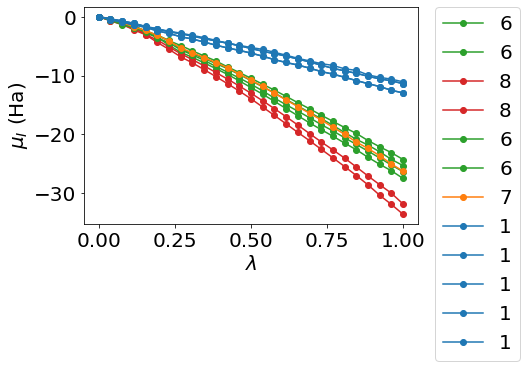

In [9]:
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,1)
color_dict = {1.0:'tab:blue', 6.0:'tab:green', 7.0:'tab:orange', 8.0:'tab:red'}
for i in range(len(com.nuclear_charges)):
#     if com.nuclear_charges[i] == 1:
#         ax.plot(lam_vals, alchpots[:,i], '-o', color=color_dict[com.nuclear_charges[i]])
    ax.plot(lam_vals, alchpots[:,i], '-o',label = com.nuclear_charges[i], color=color_dict[com.nuclear_charges[i]])
#         ax.plot(lam_vals, alchpots_long[1:,i]+lam_vals*12, '--')
#         ax.plot(lam_vals, alchpots_atom[1:,i]+lam_vals*12, '-*')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$\mu_I$ (Ha)')

#### Compare integrals

In [25]:
av_fine = atp.calculate_average_alchpots(alchpots, lam_vals, 'trapz')

In [26]:
av_fine

array([-10.97609495, -12.61406042, -13.94457532, -14.86686332,
       -12.05344251, -11.45630258, -11.55564329,  -5.38036813,
        -5.55029461,  -5.55029316,  -6.33280483,  -6.33264006])

In [25]:
# load reference data from different_resevoir_pyscf.ipynb
alchs_ref = ut.load_obj(base+'alch_pots')
alch_pots_reference = -np.array(alchs_ref)
alch_pots_reference = np.concatenate((np.zeros( (1, len(alch_pots_reference[0])) ), alch_pots_reference), axis = 0)
lam_vals_ref = np.array([0, 22, 30, 38, 44, 52])/52

In [26]:
lam_vals_ref*52

array([ 0., 22., 30., 38., 44., 52.])

In [27]:
alch_pots_reference[:,0]

array([  0.        ,  -8.53109377, -12.48194451, -16.72787267,
       -19.83084076, -24.26343672])

In [28]:
av_coarse = atp.calculate_average_alchpots(alch_pots_reference, lam_vals_ref, 'trapz')

In [29]:
av_coarse

array([-11.16897507, -12.77872974, -14.20859509, -15.11004852,
       -12.26253009, -11.62288839, -11.74960303,  -5.38749346,
        -5.54044003,  -5.54051814,  -6.36671697,  -6.36653952])

In [31]:
print(np.abs((av_fine - av_coarse)).mean())
print(np.abs((av_fine - av_coarse)).std())

0.12459261675718698
0.09727825094279796


some potentials differ quite a lot (>100mHa) -> also small lambda values important

What is the best spacing (cost vs accuracy)?
- equally spaced -> simpsons rule
- compare every 2, 4, 6, 8, 10

#### Trapezoidal vs Simpsons

In [12]:
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')

import alchemy_tools_pyscf as atp
import numpy as np
import qml
import utils_qm as ut

In [13]:
base = '/home/misa/APDFT/prototyping/atomic_energies/results/different_resevoir/pyscf/com_001212/'
alchpots = ut.load_obj(base+'alch_pots_fine')
lam_vals = np.arange(2, 54, 2)/52
alchpots = np.concatenate((np.zeros( (1, len(alchpots[0])) ), alchpots), axis = 0)
lam_vals = np.concatenate((np.zeros(1), lam_vals))

In [14]:
av2_trapz = atp.calculate_average_alchpots(alchpots, lam_vals, 'trapz')
av2_simps = atp.calculate_average_alchpots(alchpots, lam_vals, 'simps')


In [15]:
av2_trapz - av2_simps

array([-0.00233282, -0.00427446, -0.00797825,  0.00076161,  0.00279349,
        0.00061471, -0.00249642,  0.0046545 , -0.00201606, -0.00204067,
        0.00325231,  0.00322552])

In [16]:
len(lam_vals[::2])

14

In [16]:
av4_trapz = atp.calculate_average_alchpots(alchpots[::2], lam_vals[::2], 'trapz')
av4_simps = atp.calculate_average_alchpots(alchpots[::2], lam_vals[::2], 'simps', 'first')

In [17]:
av4_trapz - av4_simps

array([-0.01736299, -0.00661817, -0.01755904, -0.01258776, -0.00338907,
       -0.00872064, -0.00614399, -0.00632665, -0.0073069 , -0.00723812,
        0.00614106,  0.00616014])

In [20]:
np.abs((av2_simps - av4_simps)).mean()

0.0098600326191877

In [21]:
np.abs((av2_simps - av4_simps)).std()

0.006622336257144421